# Baseline model

**Objective of this notebook**
- load the data
- get an overview
- build baseline model and evaluate how it performs
- model evaluation

In [3]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
import pathlib
from pathlib import Path
import os
import sys
import PIL
import PIL.Image

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

try:
  import networkx as nx
  has_networkx = True
except:
  has_networkx = False

RSEED = 42

# Load the data

## defining helper functions to import the data

In [4]:
def load_bounding_box_annotations(dataset_path=''):
  bboxes = {}
  with open(os.path.join(dataset_path, 'bounding_boxes.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      image_id = pieces[0]
      bbox = map(int, pieces[1:])
      bboxes[image_id] = bbox
  return bboxes

def load_part_annotations(dataset_path=''):
  parts = {}
  with open(os.path.join(dataset_path, 'parts/part_locs.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      image_id = pieces[0]
      parts.setdefault(image_id, [0] * 11)
      part_id = int(pieces[1])
      parts[image_id][part_id] = map(int, pieces[2:])
  return parts  
  
def load_part_names(dataset_path=''):
  names = {}
  with open(os.path.join(dataset_path, 'parts/parts.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      part_id = int(pieces[0])
      names[part_id] = ' '.join(pieces[1:])
  return names  
    
def load_class_names(dataset_path=''):
  names = {}
  with open(os.path.join(dataset_path, 'classes.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      class_id = pieces[0]
      names[class_id] = ' '.join(pieces[1:])
  return names

def load_image_labels(dataset_path=''):
  labels = {}
  with open(os.path.join(dataset_path, 'image_class_labels.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      image_id = pieces[0]
      class_id = pieces[1]
      labels[image_id] = class_id
  return labels
        
def load_image_paths(dataset_path='', path_prefix=''):
  paths = {}
  with open(os.path.join(dataset_path, 'paths.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      image_id = pieces[0]
      path = os.path.join(path_prefix, pieces[1])
      paths[image_id] = path
  return paths

def load_image_sizes(dataset_path=''):
  sizes = {}
  with open(os.path.join(dataset_path, 'sizes.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      image_id = pieces[0]
      width, height = map(int, pieces[1:])
      sizes[image_id] = [width, height]
  return sizes

def load_hierarchy(dataset_path=''):
  parents = {}
  with open(os.path.join(dataset_path, 'hierarchy.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      child_id, parent_id = pieces
      parents[child_id] = parent_id
  return parents

def load_photographers(dataset_path=''):
  photographers = {}
  with open(os.path.join(dataset_path, 'photographers.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      image_id = pieces[0]
      photographers[image_id] = ' '.join(pieces[1:])
  return photographers

def load_train_test_split(dataset_path=''):
  train_images = []
  test_images = []
  with open(os.path.join(dataset_path, 'train_test_split.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      image_id = pieces[0]
      is_train = int(pieces[1])
      if is_train:
        train_images.append(image_id)
      else:
        test_images.append(image_id)
  return train_images, test_images 

''' 
# is not working therefore currently outcommented
# define dataset path and images path      
if __name__ == '__main__':
  if len(sys.argv) > 1:
    dataset_path = sys.argv[1]
  else:
    dataset_path = '/Users/friederikethies/neue_fische/ds-capstone-for-the-birds/data' # 'data/', 'data'
  print(dataset_path)
  if len(sys.argv) > 2:
    image_path = sys.argv[2]
  else:
    image_path  = 'images' # other variants tried: 'images' 'images/' and '..images/'
  print(image_path)
'''

" \n# is not working therefore currently outcommented\n# define dataset path and images path      \nif __name__ == '__main__':\n  if len(sys.argv) > 1:\n    dataset_path = sys.argv[1]\n  else:\n    dataset_path = '/Users/friederikethies/neue_fische/ds-capstone-for-the-birds/data' # 'data/', 'data'\n  print(dataset_path)\n  if len(sys.argv) > 2:\n    image_path = sys.argv[2]\n  else:\n    image_path  = 'images' # other variants tried: 'images' 'images/' and '..images/'\n  print(image_path)\n"

In [5]:
# set the paths
# replace the part /Users/friederikethies/neue_fische/ds-capstone-for-the-birds with your absolute path
dataset_path = '/Users/friederikethies/neue_fische/ds-capstone-for-the-birds/data'
image_path_complete = '/Users/friederikethies/neue_fische/ds-capstone-for-the-birds/data/images'
parts_path = '/Users/friederikethies/neue_fische/ds-capstone-for-the-birds/data/parts'

In [6]:
# Load in the image data
# Assumes that the images have been extracted into a directory called "images"
image_paths = load_image_paths(image_path_complete)
image_sizes = load_image_sizes(dataset_path)
image_bboxes = load_bounding_box_annotations(dataset_path)
image_parts = load_part_annotations(dataset_path)
image_class_labels = load_image_labels(dataset_path)
  
# Load in the class data
class_names = load_class_names(dataset_path)
class_hierarchy = load_hierarchy(dataset_path)
  
# Load in the part data
part_names = load_part_names(dataset_path)
part_ids = part_names.keys()
# part_ids.sort() # removed this (FT)
  
# Load in the photographers
photographers = load_photographers(dataset_path)
  
# Load in the train / test split
train_images, test_images = load_train_test_split(dataset_path)

In [7]:
# test if code works
# convert to dataframe 
image_paths_df = pd.DataFrame([image_paths], index=[0]).T
image_sizes_df = pd.DataFrame([image_sizes], index=[0]).T
image_bboxes_df = pd.DataFrame([image_bboxes], index=[0]).T
image_parts_df = pd.DataFrame([image_parts], index=[0]).T
image_class_labels_df = pd.DataFrame([image_class_labels], index=[0]).T
class_names_df = pd.DataFrame([class_names], index=[0]).T
class_hierarchy_df = pd.DataFrame([class_hierarchy], index=[0]).T
part_names_df = pd.DataFrame([part_names], index=[0]).T
part_ids_df = pd.DataFrame([part_ids], index=[0]).T
photographers_df = pd.DataFrame([photographers], index=[0]).T
train_images_df = pd.DataFrame.from_dict(train_images, orient='columns', dtype=None, columns=None)
test_images_df = pd.DataFrame.from_dict(test_images, orient='columns', dtype=None, columns=None)

In [8]:
from os import walk

f = []
for (dirpath, dirnames, filenames) in walk(image_path_complete):
    f.extend(dirnames)
    break

f = pd.DataFrame([f], index=[0]).T
f.to_csv(path_or_buf='data/csvs/id_main.csv')

## Load the images with tensorflow/keras

In [9]:
data_dir = pathlib.Path(image_path_complete)

In [10]:
batch_size = 32
img_height = 150
img_width = 150

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=RSEED,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 48562 files belonging to 555 classes.
Using 38850 files for training.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-10-25 16:50:53.433746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-25 16:50:53.434492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=RSEED,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 48562 files belonging to 555 classes.
Using 9712 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['0295', '0296', '0297', '0298', '0299', '0313', '0314', '0315', '0316', '0317', '0318', '0319', '0320', '0321', '0322', '0323', '0324', '0325', '0326', '0327', '0328', '0329', '0330', '0331', '0332', '0333', '0334', '0335', '0336', '0337', '0338', '0339', '0340', '0341', '0342', '0343', '0344', '0345', '0346', '0347', '0348', '0349', '0350', '0351', '0352', '0353', '0354', '0355', '0356', '0357', '0358', '0359', '0360', '0361', '0362', '0363', '0364', '0365', '0366', '0367', '0368', '0369', '0370', '0371', '0372', '0373', '0374', '0375', '0376', '0377', '0378', '0379', '0380', '0381', '0382', '0392', '0393', '0394', '0395', '0396', '0397', '0398', '0399', '0400', '0401', '0402', '0446', '0447', '0448', '0449', '0450', '0451', '0452', '0453', '0454', '0455', '0456', '0457', '0458', '0459', '0460', '0461', '0462', '0463', '0464', '0465', '0466', '0467', '0468', '0469', '0470', '0471', '0472', '0473', '0474', '0475', '0476', '0477', '0478', '0479', '0480', '0481', '0482', '0483', '0484',

### Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [15]:
# There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2022-10-25 16:50:54.266142: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


0.002571174 0.9006912


### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model 

The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the Image classification tutorial.

In [21]:
# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.InceptionV3(include_top= False,)
# 2. Freeze the base model
base_model.trainable = False

#3. Create inputs into models
inputs = tf.keras.layers.Input(shape =(img_height,img_width,3), name = "input-layer")

In [22]:
#4. Rescaling
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

#5. Pass the inputs 
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(555, activation = "softmax", name = "output-layer")(x)

# 8. Combine the inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

Shape after passing inputs through base model: (None, 3, 3, 2048)
Shape after GlobalAveragePooling2D: (None, 2048)


Choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [23]:
# 9. Compile the model
model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
                metrics = ["accuracy"])

In [24]:
history = model_0.fit(train_ds,
                                 epochs=10,
                                 steps_per_epoch = len(train_ds),
                                 #validation_data = val_data,
                                 #validation_steps = int(0.25*len(val_data)),
                                 )

Epoch 1/10


2022-10-25 16:52:15.306152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  29/1215 [..............................] - ETA: 1:55 - loss: 973.8140 - accuracy: 0.0011

2022-10-25 16:52:20.007318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  43/1215 [>.............................] - ETA: 1:56 - loss: 1127.8813 - accuracy: 0.0022

2022-10-25 16:52:21.440268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  46/1215 [>.............................] - ETA: 1:55 - loss: 1142.1372 - accuracy: 0.0027

2022-10-25 16:52:21.732830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  54/1215 [>.............................] - ETA: 1:54 - loss: 1197.8978 - accuracy: 0.0029

2022-10-25 16:52:22.522103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  77/1215 [>.............................] - ETA: 1:51 - loss: 1300.5275 - accuracy: 0.0024

2022-10-25 16:52:24.724681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  93/1215 [=>............................] - ETA: 1:50 - loss: 1364.4832 - accuracy: 0.0024

2022-10-25 16:52:26.279914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 111/1215 [=>............................] - ETA: 1:47 - loss: 1419.8325 - accuracy: 0.0025

2022-10-25 16:52:28.009895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 169/1215 [===>..........................] - ETA: 1:41 - loss: 1440.0632 - accuracy: 0.0028

2022-10-25 16:52:33.668697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 219/1215 [====>.........................] - ETA: 1:39 - loss: 1375.0325 - accuracy: 0.0030

2022-10-25 16:52:39.017241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 263/1215 [=====>........................] - ETA: 1:42 - loss: 1314.1521 - accuracy: 0.0030

2022-10-25 16:52:45.476727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 265/1215 [=====>........................] - ETA: 1:42 - loss: 1310.7596 - accuracy: 0.0029

2022-10-25 16:52:45.744389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 346/1215 [=======>......................] - ETA: 1:36 - loss: 1222.0695 - accuracy: 0.0033

2022-10-25 16:52:55.447161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-25 16:52:55.566321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 349/1215 [=======>......................] - ETA: 1:35 - loss: 1219.3579 - accuracy: 0.0033

2022-10-25 16:52:55.748046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-25 16:52:55.887948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 370/1215 [========>.....................] - ETA: 1:32 - loss: 1201.0723 - accuracy: 0.0034

2022-10-25 16:52:57.842194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 381/1215 [========>.....................] - ETA: 1:31 - loss: 1191.5428 - accuracy: 0.0034

2022-10-25 16:52:59.152145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 386/1215 [========>.....................] - ETA: 1:31 - loss: 1187.3832 - accuracy: 0.0033

2022-10-25 16:52:59.613788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 415/1215 [=========>....................] - ETA: 1:27 - loss: 1162.4333 - accuracy: 0.0034

2022-10-25 16:53:02.763737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 450/1215 [==========>...................] - ETA: 1:23 - loss: 1142.0455 - accuracy: 0.0035

2022-10-25 16:53:06.419588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 512/1215 [===========>..................] - ETA: 1:16 - loss: 1119.0454 - accuracy: 0.0037

2022-10-25 16:53:12.886687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 553/1215 [============>.................] - ETA: 1:12 - loss: 1106.2085 - accuracy: 0.0038

2022-10-25 16:53:17.619464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 581/1215 [=============>................] - ETA: 1:09 - loss: 1095.4061 - accuracy: 0.0037

2022-10-25 16:53:20.824267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 593/1215 [=============>................] - ETA: 1:08 - loss: 1091.3273 - accuracy: 0.0037

2022-10-25 16:53:22.144615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 692/1215 [================>.............] - ETA: 58s - loss: 1062.6871 - accuracy: 0.0041

2022-10-25 16:53:34.147758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 700/1215 [================>.............] - ETA: 57s - loss: 1060.9202 - accuracy: 0.0041

2022-10-25 16:53:35.195531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 724/1215 [================>.............] - ETA: 54s - loss: 1057.1061 - accuracy: 0.0042

2022-10-25 16:53:37.937487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-25 16:53:38.009478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 731/1215 [=================>............] - ETA: 54s - loss: 1056.7343 - accuracy: 0.0041

2022-10-25 16:53:38.748801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 740/1215 [=================>............] - ETA: 53s - loss: 1054.3569 - accuracy: 0.0041

2022-10-25 16:53:39.743407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 790/1215 [==================>...........] - ETA: 47s - loss: 1045.9172 - accuracy: 0.0040

2022-10-25 16:53:45.751797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 802/1215 [==================>...........] - ETA: 46s - loss: 1043.7739 - accuracy: 0.0041

2022-10-25 16:53:47.271295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-25 16:53:47.374784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 849/1215 [===================>..........] - ETA: 41s - loss: 1039.1296 - accuracy: 0.0040

2022-10-25 16:53:53.341858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 881/1215 [====================>.........] - ETA: 37s - loss: 1034.7028 - accuracy: 0.0042

2022-10-25 16:53:57.393627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 895/1215 [=====================>........] - ETA: 36s - loss: 1034.7250 - accuracy: 0.0042

2022-10-25 16:53:59.120653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-25 16:53:59.247781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 987/1215 [=======================>......] - ETA: 26s - loss: 1025.4653 - accuracy: 0.0046

2022-10-25 16:54:10.663728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1028/1215 [========================>.....] - ETA: 21s - loss: 1024.7355 - accuracy: 0.0046

2022-10-25 16:54:16.223135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1040/1215 [========================>.....] - ETA: 20s - loss: 1023.7773 - accuracy: 0.0046

2022-10-25 16:54:17.681264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-10-25 16:54:17.742419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1102/1215 [==========================>...] - ETA: 13s - loss: 1020.2849 - accuracy: 0.0048

2022-10-25 16:54:25.327946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1109/1215 [==========================>...] - ETA: 12s - loss: 1019.3082 - accuracy: 0.0048

2022-10-25 16:54:26.158889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1116/1215 [==========================>...] - ETA: 11s - loss: 1018.6745 - accuracy: 0.0048

2022-10-25 16:54:27.090461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1177/1215 [============================>.] - ETA: 4s - loss: 1015.0051 - accuracy: 0.0050

2022-10-25 16:54:34.244812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1215/1215 [==============================] - 147s 118ms/step - loss: 1014.6355 - accuracy: 0.0050
Epoch 2/10
1215/1215 [==============================] - 174s 143ms/step - loss: 910.9642 - accuracy: 0.0125
Epoch 3/10
1215/1215 [==============================] - 169s 139ms/step - loss: 899.8008 - accuracy: 0.0193
Epoch 4/10
1215/1215 [==============================] - 188s 155ms/step - loss: 879.0432 - accuracy: 0.0271
Epoch 5/10
1215/1215 [==============================] - 176s 145ms/step - loss: 866.3225 - accuracy: 0.0351
Epoch 6/10
1215/1215 [==============================] - 186s 153ms/step - loss: 826.7115 - accuracy: 0.0439
Epoch 7/10
1215/1215 [==============================] - 193s 159ms/step - loss: 832.6130 - accuracy: 0.0510
Epoch 8/10
1215/1215 [==============================] - 192s 157ms/step - loss: 802.2384 - accuracy: 0.0596
Epoch 9/10
1215/1215 [==============================] - 195s 161ms/step - loss: 785.4972 - accuracy: 0.0703
Epoch 10/10
1215/1215 [===============

## Quick visual check

ValueError: max() arg is an empty sequence

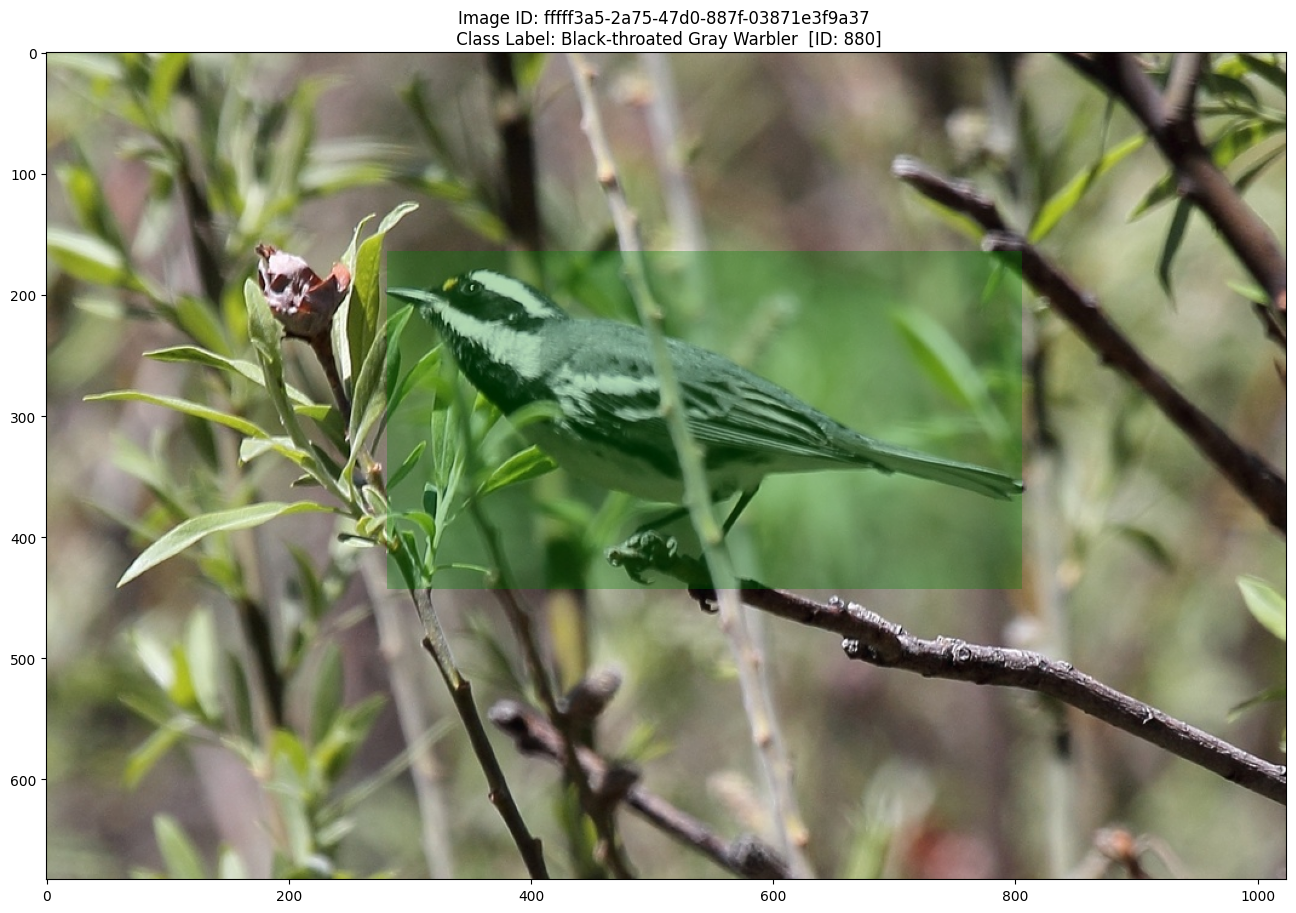

In [ ]:
# Visualize the images and their annotations
image_identifiers = image_paths.keys()
#random.shuffle(image_identifiers) 
for image_id in image_identifiers:
    image_path = image_paths[image_id]
    image = plt.imread(os.path.join(image_path_complete,image_path))
    bbox = image_bboxes[image_id]
    parts = image_parts[image_id]
    class_label = image_class_labels[image_id]
    class_name = class_names[class_label]
    
# Render the image
plt.close(1)
fig = plt.figure(1, figsize=(16, 12))
plt.imshow(image)
plt.title("Image ID: %s \n Class Label: %s  [ID: %s]" % (image_id, class_name, class_label))
    
# Render the bounding box annotations
bbox_x, bbox_y, bbox_width, bbox_height = bbox
currentAxis = plt.gca()
currentAxis.add_patch(plt.Rectangle((bbox_x , bbox_y), bbox_width, bbox_height, facecolor="green", alpha=0.3))
    
# Render the part annotations
if has_networkx:
  # Use networkx spring layout
      
  G = nx.Graph()
  part_data = []
  initial_positions = {}
  for part_id, part in enumerate(parts):
    x, y, v = part
  if v:    
    part_str = 'part_%d' % (part_id,)
    label_str = 'label_%d' % (part_id,)
    G.add_node(part_str)
    G.add_node(label_str)
    G.add_edge(part_str, label_str)
    part_data.append(part_str)
    initial_positions[part_str] = (x, y)
    initial_positions[label_str] = (x, y)
positions = nx.spring_layout(G, dim=2, k=20.0, pos=initial_positions, fixed=part_data)
      
for part_id, part in enumerate(parts):
  x, y, v = part
  if v: 
    plt.plot(x, y, 'o')
    label_str = 'label_%d' % (part_id,)
    label_position = positions[label_str]
    label_xy = (label_position[0] * bbox_width + bbox_x, label_position[1] * bbox_height + bbox_y)
    plt.annotate(
      part_names[part_id], 
      xy=(x, y),
      xycoords='data', 
      xytext= label_xy, 
      textcoords='data',
      ha='right', 
      va='bottom',
      bbox=dict(boxstyle= 'round,pad=0.5', 
        fc='yellow', 
        alpha=0.5),
      arrowprops=dict(arrowstyle='->', 
      connectionstyle='arc3,rad=0')
    )
else:
  # just a basic label annotation for the part locations
  offset = (2 * math.pi) / len(parts)
  for part_id, part in enumerate(parts):
    x, y, v = part
    if v: 
      # try to offset the part labels so that they don't overlap too badly
      dist = random.randint(35, 65)
      offset_x = dist * math.cos(offset * part_id)
      offset_y = dist * math.sin(offset * part_id)
        
      plt.plot(x, y, 'o')
      plt.annotate(
      part_names[part_id], 
      xy=(x, y), 
      xytext=(offset_x, offset_y), 
      textcoords='offset points', 
      ha='right', 
      va='bottom',
      bbox=dict(boxstyle= 'round,pad=0.5', 
        fc='yellow', 
        alpha=0.5),
      arrowprops=dict(arrowstyle='->', 
        connectionstyle='arc3,rad=0')
      )
    
plt.show(block=False)

# Print some info about the image and the annotations:
print("Image ID: %s" % (image_id,))
print("Image Path: %s" % (image_path,))
print("Image Dimensions: %d x %d" % (image_sizes[image_id][0], image_sizes[image_id][1]))
print("Photographer: %s" % (photographers[image_id],))
print("Split: %s" % ("train" if image_id in train_images else "test"))
print("Class Label Path:")
    
label_path = []
current_class_label = class_label
while current_class_label in class_hierarchy:
  label_path.append((class_names[current_class_label], current_class_label))
  current_class_label = class_hierarchy[current_class_label]
label_path.append((class_names[current_class_label], current_class_label)) # add the root node
label_path.reverse()
for depth, (class_name, class_id) in enumerate(label_path):
  line = "\t" * (depth + 1)
  print(line + "|- %s \t[ID: %s]" % (class_name, class_id))
  
print("Bounding Box Dimensions: %d x %d" % (bbox_width, bbox_height))
print("%-10s\t%-1s" % ('Part Name', 'Visibility'))
for part_id in part_ids:
  x, y, v = parts[part_id]
  print("%-10s\t%-1s" % (part_names[part_id], 'Y' if v else 'N'))
    
# Keep showing images until a button other than Enter is pressed
ri = input("Press Enter to continue. Or press any key and then enter to quit...")
if ri != '':
  break
print
print

In [ ]:
class_names['1010']

'Dark-eyed Junco (Red-backed/Gray-headed)'

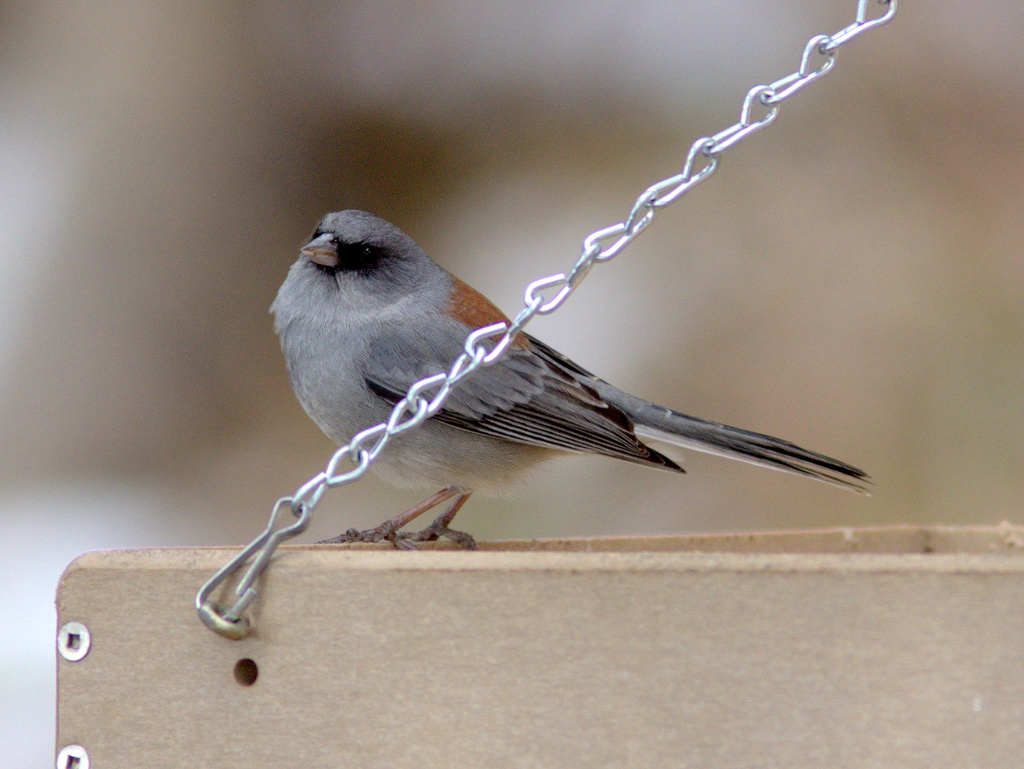

In [ ]:
Dark_eyed_Junco = list(data_dir.glob('1010/*'))
PIL.Image.open(str(Dark_eyed_Junco[0]))

## Baseline model